# Linear & Quadratic Discriminant Analysis

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import multivariate_normal  # Estimating Gaussian distribution

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.95,20.01,114.20,982.0,0.08402,0.06722,0.07293,0.05596,0.2129,...,20.58,27.83,129.20,1261.0,0.1072,0.1202,0.22490,0.11850,0.4882,0.06111
1,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.53900,0.20600,0.4378,0.10720
2,M,15.30,25.27,102.40,732.4,0.10820,0.16970,0.16830,0.08751,0.1926,...,20.27,36.71,149.30,1269.0,0.1641,0.6110,0.63350,0.20240,0.4027,0.09876
3,B,13.53,10.94,87.91,559.2,0.12910,0.10470,0.06877,0.06556,0.2403,...,14.08,12.49,91.36,605.5,0.1451,0.1379,0.08539,0.07407,0.2710,0.07191
4,B,11.30,18.19,73.93,389.4,0.09592,0.13250,0.15480,0.02854,0.2054,...,12.58,27.96,87.16,472.9,0.1347,0.4848,0.74360,0.12180,0.3308,0.12970


We have data about various tumors and whether they are Malignant, "M", or Benign, "B", as the diagnosis. Each tumor has measures recorded like their radius, perimeter, area, etc. In this notebook, we will use linear and quadratic discriminant analysis **(LDA/QDA)** to classify tumors as either malignant or benign. To do so, we will use estimate probabilities with multivariate Gaussian distributions.

# Feature Visualization
Before getting started, we should visualize the differences in the values of the features between the two class labels, malignant and benign. Features are more useful when there is a clear distinction between the data points of the two labels.

Text(0.5, 1.0, 'Texture Mean vs. Radius Mean')

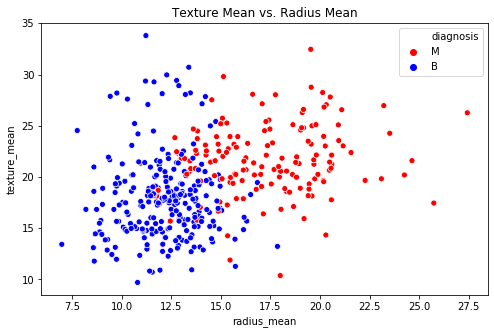

In [4]:
fig = plt.gcf()
fig.set_size_inches(8, 5)

sns.scatterplot(x="radius_mean", y="texture_mean", hue="diagnosis", palette=["red", "blue"], data=train)
plt.title("Texture Mean vs. Radius Mean")

Here is the radius mean vs. the texture mean of malignant and benign tumors. We can fit a Gaussian to just these two features of course, but it's more useful to fit multivariate Gaussians of larger dimensions and use all features in our data.

# 2b. Linear Discriminant Analysis

Before performing Linear Discriminant Analysis, it's important to standardize the data for each feature in order to get more accurate results. Larger data values tends to greatly impact the estimated probabilities coming from the Gaussian distribution, which we can help mitigate by standardizing beforehand.

In [5]:
# Standardize each feature before analysis
def standardize(train, test):
    """
    Standardizes training and testing set data based on the means and standard
    deviations of the training set. x = (x-µ)/σ
    
    :param train: training set
    :param test: testing set
    :returns: standardized training and testing set
    """
    for col in train.columns:
        if col == "diagnosis":
            continue
        mean = np.mean(train[col])
        std = np.std(train[col])
        train[col] = (train[col]-mean)/std  # standardize training data
        test[col] = (test[col]-mean)/std  # standardize testing data
    return train, test

train, test = standardize(train, test)

Now we can split the data into the two classes to calculate conditional probabilities.

In [6]:
# Split data into two classes
benign = train[train["diagnosis"] == "B"]
malignant = train[train["diagnosis"] == "M"]

We will calculate the covariance matrix of the data with all 30 features. Then we will have 2 different convariance matrices made from the data for both classes.

In [7]:
# Calculate Covariance Matrix for each class
def covariance_matrix(data):
    """
    Calculates the covariance matrix of all features for the dataset.
    
    :param data: dataset for covariance matrix
    :return: covariance matrix of data
    """
    df = data.drop(["diagnosis"], axis=1)
    for col in df.columns:
        df[col] = df[col] - np.mean(df[col])
    X = df.to_numpy()
    n = len(data)
    return (1/n)*np.dot(X.T, X)

C1 = covariance_matrix(benign)  # benign covariance matrix
C2 = covariance_matrix(malignant)  # malignant covariance matrix

In Linear Discriminant Analysis, we assume that the diagonal covariance matrix is shared amongst the classes. Since we have two different covariance matrices calculated, we can join these two matrcies together by using the weighted mean and get one joined, shared, covariance matrix.

In [8]:
# Overall Covariance Matrix with weighted average
n1 = len(benign)
n2 = len(malignant)
C = (n1*C1+n2*C2)/(n1+n2)
C  # joined covariance matrix

array([[ 0.46069695,  0.04083119,  0.44882355,  0.46061735, -0.09497714,
         0.07277864,  0.17141546,  0.24533524, -0.07583513, -0.28977725,
         0.24749563, -0.06816555,  0.24167745,  0.32588402, -0.16518063,
         0.01761937,  0.04056994,  0.10559047, -0.07224205, -0.07486241,
         0.39924598, -0.00839932,  0.38762149,  0.40085921, -0.16919382,
         0.00467344,  0.06870833,  0.1757939 , -0.09576887, -0.20542279],
       [ 0.04083119,  0.81945533,  0.0391763 ,  0.04598691, -0.20967809,
        -0.04238423, -0.00975306, -0.04388858, -0.12081096, -0.11747559,
         0.07012713,  0.42642546,  0.08542113,  0.06564065,  0.00918936,
         0.05799085,  0.040637  , -0.00277141,  0.04862049,  0.00840289,
         0.0373404 ,  0.71412407,  0.03931201,  0.04608505, -0.15832009,
        -0.01222612, -0.01020233, -0.05646394, -0.09858045, -0.0819951 ],
       [ 0.44882355,  0.0391763 ,  0.44174399,  0.45058288, -0.06091409,
         0.12048164,  0.2047978 ,  0.26669491, -0

The prediction made by LDA depends on the conditional probabilities of each class, given the features of the test data. We can calculate the conditional probabilities for each class by using Bayes' Rule:

$P(A|B) =  P(B|A)*P(A)/P(B)$

where A represents the class label and B represents the feature vector.

Since the denominators are the same for each class because we are using the same feature vector for both probabilities, we find the label that maximizes $P(B|A)*P(A)$ To calculate the conditional probability, we can estimate it with a multivariate Gaussian distribution, using the shared covariance matrix we computed above, and the means of each feature in the data. From this, we can estimate the likelihood of our feature vector occuring in the distribution described by the training data we fit.

Because we are using a shared covariance matrix between the classes, the resulting decision boundary of our model will be linear, hence the name.

In [9]:
def _LDA(features):
    """
    Performs LDA classification on one data point, given array of its features.
    
    :param features: array of feature data
    :return: label prediction
    """
    p_benign = len(benign)/len(train)  # probability of benign 
    p_malignant = len(malignant)/len(train)  # probability of malignant
    
    mean_benign = np.array(benign.mean(axis=0))  # mean of benign
    mean_malignant = np.array(malignant.mean(axis=0))  # mean of malignant
    
    pdf_benign = multivariate_normal.pdf(features, mean_benign, C)  # conditional probability given benign
    pdf_malignant = multivariate_normal.pdf(features, mean_malignant, C)  # conditional probability given malignant
    if pdf_benign * p_benign > pdf_malignant * p_malignant:
        return "B"
    else:
        return "M"

Now we can start making predictions on the testing set and evaluate the performance of our model.

In [10]:
X_train = train.drop(["diagnosis"], axis=1).to_numpy()
y_train = train["diagnosis"]
X_test = test.drop(["diagnosis"], axis=1).to_numpy()
y_test = test["diagnosis"]

def LDA(data):
    preds = np.array([])
    for i in data:
        preds = np.append(preds, _LDA(i))
    return preds

LDA_preds_train = LDA(X_train)  # LDA predictions for training set
print("LDA Training Accuracy: ", np.sum(LDA_preds_train==y_train)/len(train))
print("LDA Training Error: ", np.sum(LDA_preds_train!=y_train)/len(train))

LDA_preds_test = LDA(X_test)   # LDA predictions for testing set
print("LDA Testing Accuracy: ", np.sum(LDA_preds_test==y_test)/len(test))
print("LDA Testing Error: ", np.sum(LDA_preds_test!=y_test)/len(test))

LDA Training Accuracy:  0.9575
LDA Training Error:  0.0425
LDA Testing Accuracy:  0.9763313609467456
LDA Testing Error:  0.023668639053254437


# 2c. Quadratic Discriminant Analysis

Quadratic Discriminant Analysis introduces a slightly more complex model than LDA. We already have the covariance matrices for each class, benign and malignant, calculated above as *C1* and *C2*, respectively. In QDA, the difference is that the covariance matrices used in fitting the Gaussian are different between the 2 classes. This results in a decision boundary that is quadratic, hence the name. So, we will use C1 and C2 to calculate conditional probabilities for the multivariate Gaussian distribution, rather than the collective covariance matrix.

In [11]:
def _QDA(features):
    """
    Performs QDA classification on one data point, given array of its features.
    
    :param features: array of feature data
    :return: label prediction
    """
    p_benign = len(benign)/len(train)  # probability of benign 
    p_malignant = len(malignant)/len(train)  # probability of malignant
    
    mean_benign = np.array(benign.mean(axis=0))  # mean of benign
    mean_malignant = np.array(malignant.mean(axis=0))  # mean of malignant
    
    pdf_benign = multivariate_normal.pdf(features, mean_benign, C1)  # conditional probability of benign
    pdf_malignant = multivariate_normal.pdf(features, mean_malignant, C2)  # conditional probability of malignant
    if pdf_benign * p_benign > pdf_malignant * p_malignant:
        return "B"
    else:
        return "M"

Again, very similar to LDA, we perform QDA by calculating conditional probabilities of each class given the data point feature vector. We can calculate the conditional probabilities for each class by using Bayes' Rule:

𝑃(𝐴|𝐵)=𝑃(𝐵|𝐴)∗𝑃(𝐴)/𝑃(𝐵) 
where A represents the class label and B represents the feature vector.

Since the denominators are the same for each class because we are using the same feature vector for both probabilities, we find the label that maximizes  𝑃(𝐵|𝐴)∗𝑃(𝐴)  To calculate the conditional probability, we can estimate it with a multivariate Gaussian distribution, using different covariance matrices amongst the different classes. From this, we can estimate the likelihood of our feature vector occuring in the distribution described by the training data we fit.

In [12]:
def QDA(data):
    preds = np.array([])
    for i in data:
        preds = np.append(preds, _QDA(i))
    return preds

QDA_preds_train = QDA(X_train)  # LDA predictions for training set
print("QDA Training Accuracy: ", np.sum(QDA_preds_train==y_train)/len(train))
print("QDA Training Error: ", np.sum(QDA_preds_train!=y_train)/len(train))

QDA_preds_test = QDA(X_test)   # LDA predictions for testing set
print("QDA Testing Accuracy: ", np.sum(QDA_preds_test==y_test)/len(test))
print("QDA Testing Error: ", np.sum(QDA_preds_test!=y_test)/len(test))

QDA Training Accuracy:  0.9675
QDA Training Error:  0.0325
QDA Testing Accuracy:  0.9644970414201184
QDA Testing Error:  0.03550295857988166
